Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time:<br>
Instructor Name: Morgan Jones<br>
Blog post URL:

# Project Description

The World Health Organization (WHO) estimates that 2 million children below the age of 5 die from pneumonia every year, making it the leading cause of child mortality worldwide. The vast majority of cases and deaths are in developing countries, particularly in Africa and Southeast Asia.

Timely diagnosis of pneumonia is key for improving health outcomes for patients. It is also important to determine whether the pneumonia is caused by a bacterial or a viral infection since the treatment plans are very different depending on the cause.

One effective method of diagnosing pneumonia is by taking chest X-rays. A medical expert can identify the telltale signs of pneumonia by observing the X-rays, but some facilities in developing countries lack such an expert. This slows down the process of diagnosing the disease, leading to delays in medical intervention.

A potential solution is to create a computer model that can interpret the chest X-rays. Such a model could be made available to medical facilities across the world, helping to shorten the time it takes to diagnose pediatric pneumonia so that life-saving treatment can be provided faster.

In this project, I train a convolutional neural network (CNN) to diagnose pneumonia using a labeled set of chest X-rays.

### Data
The data used in this project was obtained from https://data.mendeley.com/datasets/rscbjbr9sj/3.

The data contains 5856 images of chest X-rays taken for children 5 years of age or younger. The images were examined by 2 medical experts to determine whether the patient has pneumonia and, if so, whether it is bacterial or viral pneumonia. A third expert validated their classifications.

The data is split into train and test directories, and each of those is split into "NORMAL" and "PNEUMONIA" directories. The images corresponding to a patient with bacterial pneumonia all start with "BACTERIA" and those with viral pneumonia start with "VIRUS". Patients without pneumonia all of images starting with "NORMAL".

Below is a breakdown of how many images there are in each directory:

train - NORMAL: 1349<br>
train - PNEUMONIA: 3883 (BACTERIA: 2538, VIRUS: 1345)<br>
test - NORMAL: 234<br>
test - PNEUMONIA: 390 (BACTERIA: 242, VIRUS: 148)

In addition to indicating whether the patient has pneumonia, the filename also includes a unique 6-digit code for each patient and a 4-digit code counting the number of images for that patient since some patients have multiple images. For example, a patient with multiple images will have their first image will end with 0001, second with 0002, and so on.

The images have a variety of dimensions and aspect ratios. They are cropped and resized to a standard size before they are input to the CNN.

Note: The zip file provided at https://data.mendeley.com/datasets/rscbjbr9sj/3 contains data of both chest X-ray images for diagnosing pneumonia and optimal coherence tomography (OCT) images for diagnosing eye conditions. I only use the chest X-ray images.

In [159]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Data Exploration

First, I just want to see how many images are in each directory

In [251]:
# Count the number of images in each directory
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        print(directory, '\t BACTERIA:',sum([1 if 'BACTERIA' in x else 0 for x in files]),
              'VIRUS:', sum([1 if 'VIRUS' in x else 0 for x in files]))
    else:
        print(directory, '\t \t NORMAL:', len(files))

train/NORMAL/ 	 	 NORMAL: 1349
train/PNEUMONIA/ 	 BACTERIA: 2538 VIRUS: 1345
test/NORMAL/ 	 	 NORMAL: 234
test/PNEUMONIA/ 	 BACTERIA: 242 VIRUS: 148


The images have different dimensions and aspect ratios. I will crop and resize the images to a common size. Below, I determine what the average aspect ratio is. I will use this for the final aspect ratio.

In [252]:
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])] + \
        [os.path.join(maindir+subdirs[1], name) for name in os.listdir(maindir+subdirs[1])] + \
        [os.path.join(maindir+subdirs[2], name) for name in os.listdir(maindir+subdirs[2])] + \
        [os.path.join(maindir+subdirs[3], name) for name in os.listdir(maindir+subdirs[3])]

img_dims = []
for img_path in names:
    if 'jpeg' in img_path:
        img = load_img(img_path, color_mode='grayscale')
        img_dims.append([img.height,img.width])
img_dims = np.array(img_dims)

0.7147827266780963


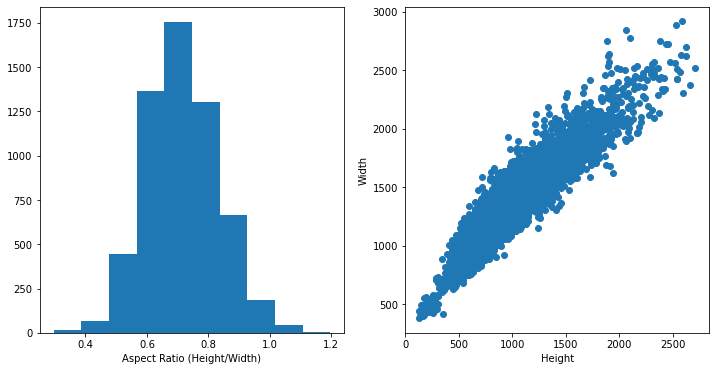

In [254]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

aspect_ratios = img_dims[:,0]/img_dims[:,1]
mean_aspect = np.mean(aspect_ratios)
print(mean_aspect)
ax[0].hist(aspect_ratios)
ax[0].set_xlabel('Aspect Ratio (Height/Width)')
ax[1].scatter(img_dims[:,0],img_dims[:,1])
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Width');

Below, I create a function that will read in an image, crop it, and resize it.

I could just resize without cropping, but this would result in stretching the image either vertically or horizontally. By cropping first, I avoid stretching the images.

The way I crop the images is by checking whether the image is too tall or too wide (compared to the average aspect ratio). If it is too tall, I will crop equal amounts from the top and bottom of the image to achieve the desired aspect ratio. If it is too wide, I crop equal amounts from the left and right.

In [275]:
def crop_resize_image(filepath, dims=None, rescale=None):
    """
    Reads in an image, crops it, and resizes it so that the final array has dimensions dims.
    Input:
    filepath: Full directory path to image.
    dims: Desired dimensions of image as tuple. Default is None, in which case no cropping or resizing is done.
    rescale: Number by which to multiply the image. Default is to not rescale.
    """
    img = load_img(filepath, color_mode='grayscale')
    if dims == None:
        img_array = img_to_array(img)
    # Crop and resize if dims is specified
    else:
        desired_aspect = dims[1]/dims[0]
        if img.height/img.width > desired_aspect:
            desired_height = img.width * desired_aspect
            cut = np.round((img.height - desired_height)/2,0)
            img_crop = img.crop((0,cut,img.width,img.height-cut))
        else:
            desired_width = img.height / desired_aspect
            cut = np.round((img.width - desired_width)/2,0)
            img_crop = img.crop((cut,0,img.width-cut,img.height))
        img_resize = img_crop.resize(dims)
        img_array = img_to_array(img_resize)
        
    # Rescale the image if rescale is defined
    if rescale != None:
        img_array *= rescale
        
    return img_array[:,:,0]

In [276]:
directory = maindir + subdirs[1]
files = os.listdir(directory)
files = [x for x in files if 'jpeg' in x]
# Desired width of images
width = 180
dimensions = (int(np.round(mean_aspect*width,0)), width)
img_array = crop_resize_image(directory+files[0], dimensions, 1/255)
img_array

array([[0.18431373, 0.17254902, 0.16862746, ..., 0.26666668, 0.24705884,
        0.23529413],
       [0.19607845, 0.18039216, 0.17254902, ..., 0.31764707, 0.26666668,
        0.24313727],
       [0.21176472, 0.20000002, 0.21960786, ..., 0.2901961 , 0.3137255 ,
        0.2509804 ],
       ...,
       [0.5058824 , 0.5568628 , 0.60784316, ..., 0.6901961 , 0.7058824 ,
        0.7176471 ],
       [0.49411768, 0.54509807, 0.59607846, ..., 0.6627451 , 0.6862745 ,
        0.69803923],
       [0.4901961 , 0.5411765 , 0.59607846, ..., 0.64705884, 0.6509804 ,
        0.6745098 ]], dtype=float32)

Some patients have multiple X-rays taken. Below I determine how many unique patients there are.

In [243]:
files = os.listdir(maindir+subdirs[1])
files = [x for x in files if 'jpeg' in x]
files_split = np.array([x.split('-') for x in files])
files_split
df = pd.DataFrame(data=files_split, columns=['type','patientID','photoID'])
df

,type,patientID,photoID
0,BACTERIA,1008087,0001.jpeg
1,BACTERIA,1025587,0001.jpeg
2,BACTERIA,1027194,0001.jpeg
3,BACTERIA,1033441,0001.jpeg
4,BACTERIA,103798,0001.jpeg
...,...,...,...
3878,VIRUS,9934736,0003.jpeg
3879,VIRUS,9947411,0002.jpeg
3880,VIRUS,9962961,0002.jpeg
3881,VIRUS,9963654,0001.jpeg


In [244]:
df['photoID'] = df['photoID'].apply(lambda x: int(x[0:4]))
df

,type,patientID,photoID
0,BACTERIA,1008087,1
1,BACTERIA,1025587,1
2,BACTERIA,1027194,1
3,BACTERIA,1033441,1
4,BACTERIA,103798,1
...,...,...,...
3878,VIRUS,9934736,3
3879,VIRUS,9947411,2
3880,VIRUS,9962961,2
3881,VIRUS,9963654,1


In [256]:
df.groupby(['patientID','type']).min()[140:160]

photoID
patientID type             
1568530   BACTERIA        1
          VIRUS           2
1570982   BACTERIA        1
          VIRUS           2
1576543   BACTERIA        1
1580360   BACTERIA        1
1584380   BACTERIA        1
          VIRUS           4
1591633   BACTERIA        1
          VIRUS           2
1596026   BACTERIA        1
          VIRUS           2
1602168   BACTERIA        1
          VIRUS           3
1612812   BACTERIA        1
          VIRUS           5
1614511   BACTERIA        1
          VIRUS           2
1620679   BACTERIA        1
          VIRUS           9

In [158]:
for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        files_sub = [x for x in files if 'BACTERIA' in x]
        files_split = np.array([x.split('-') for x in files_sub])
        bacteria_count = len(np.unique(files_split[:,1]))
        files_sub = [x for x in files if 'VIRUS' in x]
        files_split = np.array([x.split('-') for x in files_sub])
        virus_count = len(np.unique(files_split[:,1]))
        print(directory, '\t BACTERIA:', bacteria_count, 'VIRUS:', virus_count)
        
    else:
        files_sub = [x for x in files if 'NORMAL' in x]
        files_split = np.array([x.split('-') for x in files_sub])
        normal_count = len(np.unique(files_split[:,1]))
        print(directory, '\t \t NORMAL:', normal_count)

train/NORMAL/ 	 	 NORMAL: 1008
train/PNEUMONIA/ 	 BACTERIA: 1360 VIRUS: 1090
test/NORMAL/ 	 	 NORMAL: 229
test/PNEUMONIA/ 	 BACTERIA: 77 VIRUS: 126


All of the numbers are lower than the previous numbers because we are excluding all but the first image per patient. I notice that numbers corresponding to patients with pneumonia went down more than those without pneumonia:

74.7% of images in train/NORMAL/ are considered a patient's first image.<br>
63.1% of images in train/PNEUMONIA/ are considred a patient's first image.

This indicates that patients with pneumonia tend to have more X-rays in the data than those that do not. My best guess as to why is that patients with pneumonia are beginning to show symptoms, so doctors take more X-rays to make sure they are able to identify what is wrong.

Going forward, I am only going to use the first image for each patient. The reason for this is that I want the images I use to be independent. If I use multiple images of one patient, then they will not be independent.

One thing that will make obtaining one image per patient a little harder is that some images appear to be missing for patients with viral pneumonia. The first image for each patient is supposed to end with "0001.jpeg", but some patients do not have a "0001" image.

1032 1152
C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/train/PNEUMONIA/BACTERIA-1008087-0001.jpeg


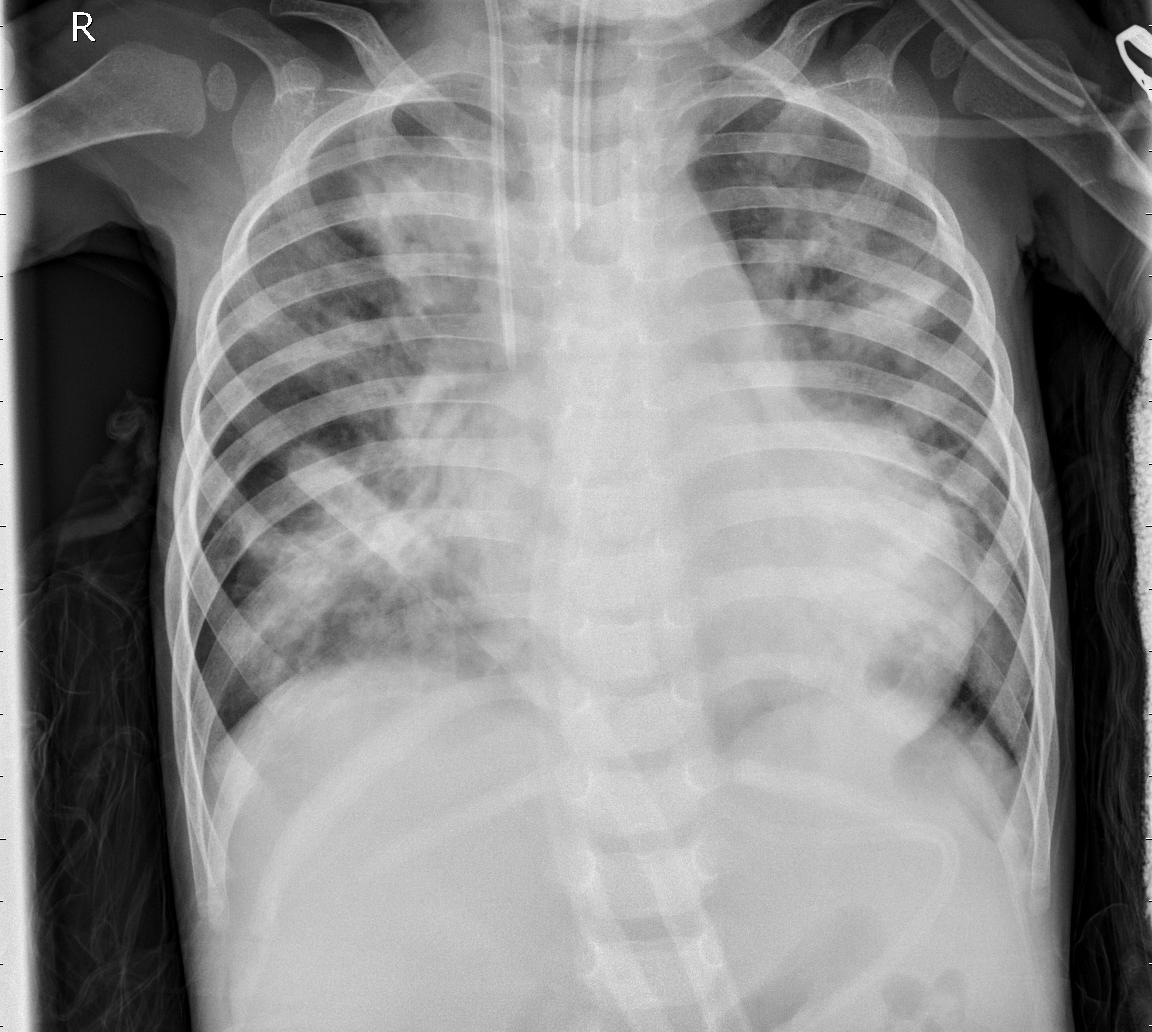

In [266]:
#names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])]
names = os.listdir(maindir+subdirs[1])
names = [x for x in names if 'jpeg' in x]
img_path = maindir+subdirs[1]+names[0]
img = load_img(img_path)
print(img.height,img.width)
print(img_path)
img

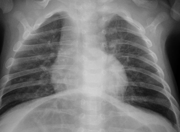

In [260]:
desired_aspect = 132/180
if img.height/img.width > desired_aspect:
    desired_height = img.width * desired_aspect
    cut = np.round((img.height - desired_height)/2,0)
    img_crop = img.crop((0,cut,img.width,img.height-cut))
else:
    desired_width = img.height / desired_aspect
    cut = np.round((img.width - desired_width)/2,0)
    img_crop = img.crop((cut,0,img.width-cut,img.height))

img_resize = img_crop.resize((180,132))
#img_crop
img_resize

In [91]:
0.7332838*180

131.991084

(1198, 1430, 3)


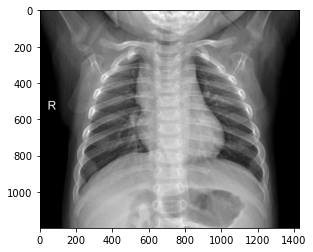

In [8]:
img_array = img_to_array(img)
print(img_array.shape)
plt.imshow(img_array[:,:,0], cmap='gray')